# Aplicación de un Modelo de Interacción Espacial a datos departamentales

Datos utilizados como variables independientes:

- La población total en origen y destino
- Totales de personas que declaran haber vivido antes en el departamento de origen
- Distancias y logaritmo de la distancia entre centros medios de población
- Dummy de límites compartidos
- Largo del límite compartido
- El PBI en el departamento de destino y el logaritmo de dicho valor

In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score, mean_squared_error
import tabulate
from operator import add

from shapely import wkt
from shapely.geometry import shape, LineString, Point
    
# funciones desarrolladas
from functions.agrupar_dfs_censo import *
from functions.cargar_data import *
from functions.impresion import *
from functions.geograficas import *
from functions.graficas import *
from functions.modelos import *

size, font, font_legend = size_font()

In [2]:
# carga capas de datos geográficos
deptos, deptos_sim, localidad, centro_pobl, capital = cargar_datos_geo()

# carga migrantes internos
p_migr = cargar_migrantes_internos()

# carga poblacion por depto
pobl = recuperar_poblacion_2011()

# carga datos diádicos
dd_deptos = cargar_dd_deptos()
dd_deptos.head(3)

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,dummy_limit,empresas_origen,empresas_destino,menores_25_origen,menores_25_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,False,3124,55,456072,30880,16.469807,13.322404,MONTEVIDEO,ARTIGAS,1.000000e-07
1,103,1,3,33127,3757,7904,0,1318755,520173,22544,...,True,3124,563,456072,197993,18.273415,10.023224,MONTEVIDEO,CANELONES,6.010700e+01
2,104,1,4,1387,162,401,1349,1318755,84698,393703,...,False,3124,88,456072,33360,16.651595,12.883352,MONTEVIDEO,CERRO LARGO,1.000000e-07


Dada la menor complejidad, se comienza por el análisis de los flujos entre departamentos.
La base de personas del Censo INE 2011 se filtra según el siguiente criterio:
- Variable "PERMI07" (lugar de residencia 5 años antes) con valores:
    - 2 = en otra localidad o paraje de este departamento
    - 3 = en otro departamento
    
Se excluyen habitantes de localidades rurales.

La tabla resultante contiene un departamento de origen, uno de destino y una cantidad de personas que declaran haber vivido antes en el departamento de "origen", habiendo sido relevadas en el departamento de "destino" al momento de la aplicación del formulario censal.


### El perfil de la migración interna

Algunas características de la población migrante interna:

- el perfil más joven y feminizado de quienes migran hacia Montevideo.

- el perfil de familias completas, integradas por parejas de entre 30 y 40 años con niños, de quienes migran desde Montevideo.

In [3]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr[['depto_origen', 'depto_destino']]

flujos_deptos = flujos_deptos[flujos_deptos.depto_origen != flujos_deptos.depto_destino]

flujos_deptos['personas_mig'] = 1

# agrupa y cuenta
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).sum()

print('Cantidad de díadas ', grupo.shape[0])

# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.pivot_table(flujos_deptos,
                        index ='depto_origen',
                        columns='depto_destino',
                        fill_value=0,
                        aggfunc=sum,
                        margins=True,
                        margins_name='Total')
matrix

Cantidad de díadas  342


personas_mig                                                   \
depto_destino            1     2      3     4     5     6     7     8     9   
depto_origen                                                                  
1                        0   914  33127  1387  2100   982   378  1026   825   
2                     2395     0    536    20   167    33    21    40    15   
3                    11162    74      0   274   422   223    82   670   403   
4                     1805    15    435     0    63    67     5    73   131   
5                     2690    28    366    20     0    63    69    53    19   
6                     1610    32    466    64    70     0   149   404    67   
7                      735     2    162    13    86    90     0    76     5   
8                     1420    13    892    37   107   307    84     0   163   
9                     1264     7    446    64    39    29    17   138     0   
10                    2333    46    862   208   196    75    58   121   407   
11                    2096    75    434    35   151    55    29    57    37   
12                    1219    30    316    20   176    54    77    27    15   
13                    2390   102    584   162    77    50    22    63    49   
14                    1435     8    407    59    49    18     7    45   130   
15                    2481   380    543    18   134    14    20    48    20   
16                    1852    15    689    31   452    59   122   252    44   
17                    1922     9    293    12  1053    57    90    40    33   
18                    2611    50    596   168    79   304    79    92    50   
19                    1024    10    259   409    41    91     2    58   172   
Total                42444  1810  41413  3001  5462  2571  1311  3283  2585   

                                                                            \
depto_destino     10    11    12    13    14    15    16    17    18    19   
depto_origen                                                                 
1               3914  1075   886  1665  1266  1547  4209  1173  1421   760   
2                472   200    57   146    47   794    92    24   100     5   
3               1345   148   154   320   360   159   908   154   251   124   
4                810    61    41   145    95    19    49    34   135   476   
5                309    71    88    34    35    68   269   513    34    23   
6                198    59    62    42    61    28   124    32   212    77   
7                 79    30    36    10    13    17   116    85    29    14   
8                310    47    30    46    62    19   321    51    68    64   
9                936    28    11    25   150    15    45    11    45   221   
10                 0    95    95   117   535    98   131   110    71   259   
11               420     0   640    66    50   480   116    98   229    25   
12               223   516     0    54    48   133   107   270    89     9   
13               227   143    36     0    46   120    99    25   546    57   
14               952    32    30    17     0    29    45    18    21   162   
15               484   564   161    97    38     0    99    75   166     8   
16               230    59    55    32    47    30     0   112    53    23   
17               335   181   372    18    46    98   147     0    41    16   
18               363   261   134   421    35   174    88    72     0    32   
19               776    16    16    23   174    13    28    25    38     0   
Total          12383  3586  2904  3278  3108  3841  6993  2882  3549  2355   

                       
depto_destino   Total  
depto_origen           
1               58655  
2                5164  
3               17233  
4                4459  
5                4752  
6                3757  
7                1598  
8                4041  
9                3491  
10               5817  
11               5093  
12               3383  
13               4798  
14               

In [4]:
# función para hacer lineas a partir de códigos origen-destino y una geografía conocida
# https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb

# aplica dd_deptos
flows = odflow(dd_deptos, 'depto_origen', 'depto_destino', 'personas_mig', deptos, 'cod_ine')

# guarda como geopaquete
# flows.to_file("capas/deptos_mig_recientes_2011.gpkg", layer='flujos', driver="GPKG")

In [5]:
# guarda para webmap
cols_links = ['depto_destino', 'depto_origen','personas_mig']
links = pd.DataFrame(flows[cols_links])
links.columns = ['target', 'source', 'flows']
# links.to_csv('webmap_flows/data/links.csv', index= False)

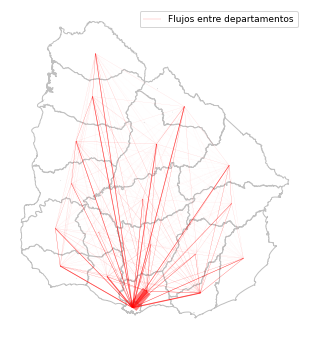

In [6]:
# plot de flujos
f, ax = plt.subplots(1,figsize=(8,6))

# apaga ejes
plt.axis('off')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

# capa de departamentos
deptos.plot(color='w', edgecolor='silver' ,ax=ax)

# máximo de flujos para escalado
maxflow = float(max(flows['personas_mig']))

# título
# pl.title("Representación gráfica de las migraciones recientes", size=10)

# plotea flows, calcula ancha de línea con una función sobre 'personas_mig'
flows.plot(linewidth = flows.apply(lambda x: (x['personas_mig']/maxflow)*10, axis=1),
           color= 'red',
           ax=ax,
           label='Flujos entre departamentos',
           alpha=0.5)

ax.set_aspect('equal')

# referencias
plt.legend(fontsize=9)

metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

# plt.savefig('mapas_graficas/links_depto.pdf',
#            bbox_inches='tight',
#            metadata = metadatos_figs )

## Gráficas de distancia

#### Totales

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_distancia.pdf


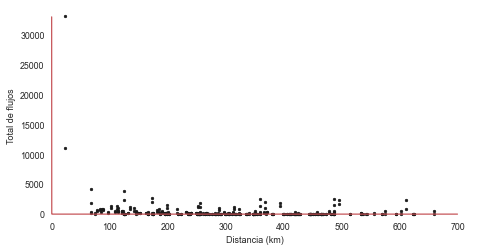

In [7]:
sns.set(font="Arial")

sns.set_context("paper", rc={"font.size":size,
                             "axes.titlesize":size,
                             "axes.labelsize":size})   

sns.set_style("white")

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(8,4))

# plot de los puntos
ax.scatter(dd_deptos['dist']/1000, dd_deptos['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.0055, 700, 1000)
yvals = np.power(xvals, -2)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
[ax.spines[i].set_visible(False) for i in ['right', 'top', 'left', 'bottom']]

# etiquetas
ax.set_ylabel("Total de flujos", font='Arial')
ax.set_xlabel("Distancia (km)", font='Arial')

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

# se ven dos outlyers claramente, deben ser Mvdeo y Canelones.
save_chart('modelos_flujos_vs_distancia.pdf', metadatos_figs)

#### Sin Montevideo

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_distancia_sin_MVO.pdf


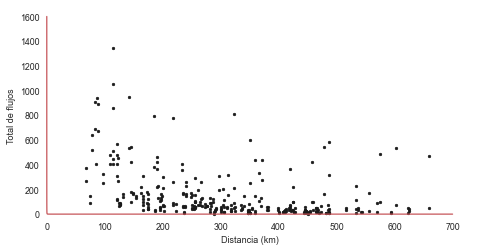

In [15]:
# mismo gráfico sin Mvdeo.
sin_mvo = dd_deptos[(dd_deptos['depto_origen'] > 1) & (dd_deptos['depto_destino'] > 1)]

# Gráfico de flujos contra distancia
f, ax = plt.subplots(1, figsize=(8,4))

# plot de los puntos
ax.scatter(sin_mvo['dist']/1000, sin_mvo['personas_mig'], marker='.', color='k')

# crea la linea roja
xvals = np.geomspace(0.025, 700, 100)
yvals = np.power(xvals, -2)

# la agrega al plot
ax.plot(xvals, yvals, color='r')

# hide spines
hide_spines(ax, todos=True)

# Etiquetas
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Distancia (km)")

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

save_chart('modelos_flujos_vs_distancia_sin_MVO.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pob_origen.pdf


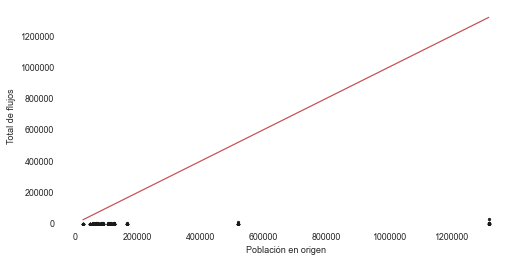

In [21]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(dd_deptos['pob_origen'], dd_deptos['personas_mig'], marker='.', color='k')

xvals = np.linspace(dd_deptos['pob_origen'].min(), dd_deptos['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, dd_deptos['pob_origen'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

plt.ticklabel_format(style='plain')

save_chart('modelos_flujos_vs_pob_origen.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pob_origen_sin_MVO.pdf


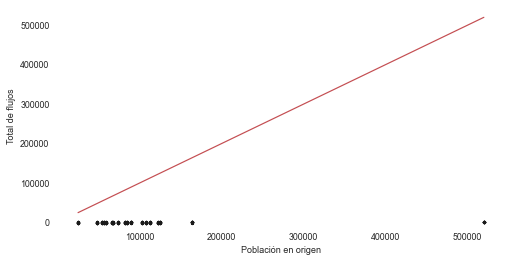

In [22]:
# gráfico de flujos contra población en el origen
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(sin_mvo['pob_origen'], sin_mvo['personas_mig'], marker='.', color='k')

xvals = np.linspace(sin_mvo['pob_origen'].min(), sin_mvo['pob_origen'].max(), 100)
yvals = np.power(xvals, 1.0)

# Now add function line to plot
ax.plot(xvals,yvals,color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-5000, sin_mvo['pob_origen'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("Población en origen")

save_chart('modelos_flujos_vs_pob_origen_sin_MVO.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pbi_destino.pdf


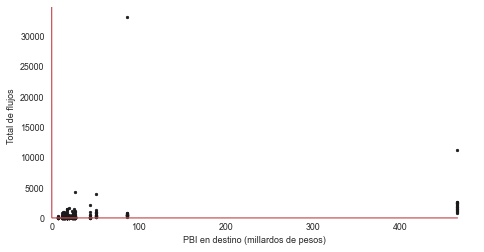

In [51]:
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(dd_deptos['pbi_destino_millardos'], dd_deptos['personas_mig'], marker='.',color='k')

# crea la linea roja
xvals = np.geomspace(0.005, max(dd_deptos['pbi_destino_millardos']), 500)
yvals = np.power(xvals, -2.0)
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-1000, dd_deptos['personas_mig'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino (millardos de pesos)")



save_chart('modelos_flujos_vs_pbi_destino.pdf', metadatos_figs)

Se guardó la gráfica en mapas_graficas/modelos_flujos_vs_pbi_destino_sin_MVO.pdf


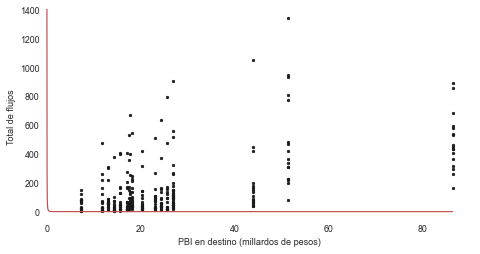

In [50]:
# Plot de PBI en destino contra personas migrantes
# Plot de PBI en destino contra personas migrantes
f, ax = plt.subplots(1, figsize=(8,4))

# Plot data points
ax.scatter(sin_mvo['pbi_destino_millardos'], sin_mvo['personas_mig'], marker='.',color='k')

# crea la linea roja
xvals = np.geomspace(0.000000001, max(sin_mvo['pbi_destino_millardos']), 500000)
yvals = np.power(xvals, -2.0)
ax.plot(xvals, yvals, color='r')

# need to set the ylim to the domain of the origin pops, so we see the full line.
ax.set_ylim(-100, sin_mvo['personas_mig'].max()*1.05)

# hide spines
hide_spines(ax, todos=True)

ax.tick_params(axis='x', pad=-6)
ax.tick_params(axis='y', pad=-18)

# Add some labels
ax.set_ylabel("Total de flujos")
ax.set_xlabel("PBI en destino (millardos de pesos)")

save_chart('modelos_flujos_vs_pbi_destino_sin_MVO.pdf', metadatos_figs)

In [12]:
dd_deptos.head()

,cod,depto_origen,depto_destino,personas_mig,personas_mig_18_25,personas_mig_26_35,personas_mig_100k,pob_origen,pob_destino,dist,...,dummy_limit,empresas_origen,empresas_destino,menores_25_origen,menores_25_destino,log_pbi_destino,log_dist,nom_depto_orig,nom_depto_des,largo_limite_km
0,102,1,2,914,114,247,891,1318755,73377,610726,...,False,3124,55,456072,30880,16.469807,13.322404,MONTEVIDEO,ARTIGAS,1.000000e-07
1,103,1,3,33127,3757,7904,0,1318755,520173,22544,...,True,3124,563,456072,197993,18.273415,10.023224,MONTEVIDEO,CANELONES,6.010700e+01
2,104,1,4,1387,162,401,1349,1318755,84698,393703,...,False,3124,88,456072,33360,16.651595,12.883352,MONTEVIDEO,CERRO LARGO,1.000000e-07
3,105,1,5,2100,236,683,1991,1318755,123203,172773,...,False,3124,60,456072,43030,17.594887,12.059734,MONTEVIDEO,COLONIA,1.000000e-07
4,106,1,6,982,125,321,924,1318755,57084,198970,...,False,3124,40,456072,22663,16.382300,12.200909,MONTEVIDEO,DURAZNO,1.000000e-07


## Modelo restringido en origen

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$

dónde

2 $$O_{i} = \sum_{j}T_{ij}$$
3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$

En el modelo restringido en origen $O_{i}$ no tiene parámetro dado que representa valores conocidos. $A_{i}$ es un factor de balance que refiere a cada origen $i$. Más específicamente $A_{i}$ permite que la suma de los valores estimados sea igual al total conocido $O_{i}$

El modelo es re-especificado como un modelo de regresión de Poisson, aplicando el logaritmo, transformando la ecuación 1 en la siguiente:

4   $$ \lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$


En el modelo re-especificado, $\mu_{i}$ suplanta a $A_{i}O_{i}$.



In [ ]:
# carga datos guardados previamente
# respalda el objeto para usarlo en el otro modelo
dd_deptos_ps = cargar_dd_deptos()
dd_deptos_ps.head(3)

Especificación del modelo sin intercepto (dado por el valor -1 en la fórmula).

Esto quiere decir que todos lo $A_{i}O_{i}$ son estimados contra in intercepto de 0.

Incluir el intervalo significaría usar el primer departamento en la variable "nom_depto_orig" como intercepto, e interpretar todas las demás categorías con respecto a eso.

In [ ]:
# define el string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

# la desviación y el coef de chi cuadrado no son buenas señales
# https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
# https://www.medcalc.org/manual/chi-square-table.php

In [ ]:
# guarda en latex
# prodSim_latex = prodSim.summary().as_latex()
# f = open("tablas/prodSim.tex", "w")
# f.write(prodSim_latex)
# f.close()

In [ ]:
# imprime parámetros
variables= ['log_pbi_destino', 'log_dist']

params, params_str = get_gml_params(prodSim, variables)

print_params(variables, params_str)

De los resultados se desprende un parámetro $\alpha$ relacionado a la actractividad del destino de **0,8527**.

El parámetro $\beta$ relativo al decaimiento por la distancia es de **-0,7830**.

El coeficiente para cada origen es el valor registrado $A_{i}O_{i}$ para ese origen.

### Estimación del modelo restringido en origen

Los parámetros calculados se insertan en la ecuación presentada anteriormente:

In [ ]:
# imprime la ecuación
alpha = params_str[0]
beta =  params_str[1]
ij = '{ij}'

def get_eq_string(alpha, beta):
    eq_str='''\lambda_{2} = \exp( \mu_i + {0} ln W_j  + ({1} ln d_{2}))'''.format(alpha, beta, ij)
    return eq_str

printmath(get_eq_string(alpha, beta))

In [ ]:
# crea la sumatoria de migrantes en origen (Oi)
O_i = dd_deptos_ps.groupby('depto_origen')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'O_i'})

# crea la sumatoria de migrantes en destino (Di)
D_j = dd_deptos_ps.groupby('depto_destino')['personas_mig'].sum().to_frame().rename(columns = {'personas_mig':'D_j'})

# pega ambas variables con el df
dd_deptos_ps = dd_deptos_ps.merge(O_i, left_on='depto_origen', right_index=True)
dd_deptos_ps = dd_deptos_ps.merge(D_j, left_on='depto_destino', right_index=True)

dd_deptos_ps.head()

In [ ]:
# recupera los parámetros del modelo
mu_i = prodSim.params.to_frame()

# elimina caractérres no numéricos para poder pegar
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^ ABCDEFGHIJKLMNÑOPQRSTUVWXYZ]','', regex=True).values)),
            inplace=True)

# renombre columna
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# merge
dd_deptos_ps = dd_deptos_ps.merge(mu_i, left_on='nom_depto_orig', right_index=True)

dd_deptos_ps.head(3)

In [ ]:
# genera estimación redondeada
def prod_sim_est(df, variables, alpha, beta):
    "Estimación del modelo imputando los parámetros alfa y beta previamente calculados"
    prodsimest = np.exp(df['mu_i'] + alpha * df[variables[0]] + beta * df[variables[1]])
    return round(prodsimest)

In [ ]:
# recupera alpha y beta, previamente guardados en la lista de parámetros
alpha, beta = [i for i in params]

# estima y guarda en columna "podsimtest"
dd_deptos_ps['prodsimest'] = prod_sim_est(dd_deptos_ps, variables, alpha, beta)
dificil=prod_sim_est(dd_deptos_ps, variables, alpha, beta)

#### La forma fácil, aprovechando *statsmodel*

In [ ]:
# a pesar de lo anterior, se podrían acceder directamente a las predicciones
dd_deptos_ps = cargar_dd_deptos()
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
model = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson())
prodSim = model.fit()

# predicción
pred = prodSim.get_prediction(dd_deptos_ps)
dd_deptos_ps['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

In [ ]:
dd_deptos_ps.head()

In [ ]:
# comparación de las predicciones con ambas formas, debe dar suma cerp
facil = pred.summary_frame()['mean'].round(0).astype(float)
print(sum(facil-dificil))

In [ ]:
# matriz de flujos estimada por el modelo
dd_deptos_ps['depto_origen'] = dd_deptos_ps.depto_origen.astype(int)

matrix_prodsim = pd.pivot_table(dd_deptos_ps,
                                values='prodsimest',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_prodsim.Total = matrix_prodsim.Total.astype(int)

matrix_prodsim

In [ ]:
matrix

In [ ]:
# se define este diccionario para recodificar el índice, con abreviaturas
deptos_dict = {
    1:	'Mvdeo.',
    2:	'Artigas',
    3:	'Can.',
    4:	'C. Largo',
    5:	'Colonia',
    6:	'Durazno',
    7:	'Flores',
    8:	'Florida',
    9:	'Lavalleja',
    10:	'Maldonado',
    11:	'Paysandú',
    12:	'R. Negro',
    13:	'Rivera',
    14:	'Rocha',
    15:	'Salto',
    16:	'San José',
    17:	'Soriano',
    18:	'Tacuarembó',
    19:	'T. y Tres'
        }

In [ ]:
# se determina el formato de columnas para exportación en latex
def format_cols_latex(ancho, ncols):
    colformato = 'lp{' + ancho + 'cm}' + ('p{' + ancho + 'cm}') * ncols
    return colformato

colformato = format_cols_latex('0.7', 19 )

In [ ]:
# exporta a latex
matrix_prodsim_tex = matrix_prodsim.rename(index=deptos_dict)

# matrix_prodsim_tex.to_latex(buf= "tablas/prodsim_matriz_orig_dest.tex",
# bold_rows=False,
# column_format = colformato,
# float_format="%.2f",
# caption= 'Matriz de movimientos entre departamentos estimada mediante SIM restringido en origen.')

Se puede identificar la coincidencia de la matriz de los datos originales con la de los datos estimados en la columna de origen $O_{i}$, con leves diferencias producto del redondeo.

$$\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$$

In [ ]:
print_scores(dd_deptos_ps, 'personas_mig', 'prodsimest', 'restringido en origen')

In [ ]:
predicted_counts = dd_deptos_ps.prodsimest.values
actual_counts =    dd_deptos_ps.personas_mig.values

fig = plt.figure(figsize=(12, 4))

predicted, = plt.plot(dd_deptos_ps.index, predicted_counts, 'g-', label='Predicted')
actual, = plt.plot(dd_deptos_ps.index, actual_counts, 'r-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

In [ ]:
# con train-test split
dd_deptos_ps = cargar_dd_deptos()

mask = np.random.rand(len(dd_deptos_ps)) < 0.8

df_train = dd_deptos_ps[mask]
df_test = dd_deptos_ps[~mask]

In [ ]:
df_test.head()

In [ ]:
formula = "personas_mig ~ nom_depto_orig + log_pbi_destino + log_dist -1"
model = smf.glm(formula=formula, data=df_train, family = sm.families.Poisson())
prodSim = model.fit()

# predicción
pred = prodSim.get_prediction(df_test)
pred.summary_frame()['mean'].round(0).astype(int)

In [ ]:
predicted_counts = pred.summary_frame()['mean'].round(0).astype(int)
actual_counts = df_test.personas_mig

fig = plt.figure(figsize=(8, 4))

predicted, = plt.plot(df_test.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(df_test.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

In [ ]:
fig = plt.figure()
sns.regplot(x=predicted_counts, y=actual_counts, line_kws={"color": "green"})

fig.suptitle('Groud truth vs. estimaciones del modelo')
plt.xlabel('Valores estimados')
plt.ylabel('Groud truth')

In [ ]:
# genera matriz de diferencias
gt_array = matrix.iloc[0:19, 0:19].values
pred_array = matrix_prodsim.iloc[0:19, 0:19].values

delta = abs(gt_array-pred_array).astype(np.double).round(0)
np.fill_diagonal(delta, np.nan)

In [ ]:
# imprime la matriz de las diferencias
fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111)
cax = ax.matshow(delta, cmap='Blues')

nomdep = cargar_nombres()
plt.xticks(np.arange(0, 19, step=1), labels=nomdep, rotation=90)
plt.yticks(np.arange(0, 19, step=1), labels=nomdep)

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

#### **Otro modelo restringido en producción con la *dummy* de límites compartidos como predictor**

**Este modelo es similar al aplicado en R, devolviendo los mismos resultados en ambas plataformas**

In [ ]:
# recarga data
dd_deptos_ps = cargar_dd_deptos()
dd_deptos_ps.head(2)

In [ ]:
# define el string tomado como fórmula
formula = "personas_mig ~ nom_depto_orig + dummy_limit + np.log(largo_limite) + log_pbi_destino + pbi_porcen_des + log_dist -1"

# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps, family = sm.families.Poisson()).fit()

# resultados
prodSim.summary()

In [ ]:
pred = prodSim.get_prediction(dd_deptos_ps)

dd_deptos_ps['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

print_scores(dd_deptos_ps, 'personas_mig', 'prodsimest', 'restringido en origen')

In [ ]:
# guarda
prodSim.save('modelos/restringido_origen__siMVO_v1.pkl')

dd_deptos_ps['prodsimest'].head()
print(dd_deptos_ps.shape)

In [ ]:
# matriz de los valores estimados
pd.pivot_table(dd_deptos_ps,
values='prodsimest',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True,
margins_name='Total')

#### Mismo modelo excluyendo Mvdeo.

In [ ]:
# recarga data
dd_deptos_ps = cargar_dd_deptos()

dd_deptos_ps_sin_mvo = dd_deptos_ps.loc[~((dd_deptos_ps.depto_origen==1) | (dd_deptos_ps.depto_destino==1))].reset_index(drop=True).copy()
print(dd_deptos_ps_sin_mvo.shape)
dd_deptos_ps_sin_mvo.head()

In [ ]:
# entrena y ajusta el modelo
prodSim = smf.glm(formula=formula, data=dd_deptos_ps_sin_mvo, family = sm.families.Poisson()).fit()

# guarda el modelo
prodSim.save('modelos/restringido_origen__noMVO_v1.pkl')

# resultados
prodSim.summary()

In [ ]:
pred = prodSim.get_prediction(dd_deptos_ps_sin_mvo)

dd_deptos_ps_sin_mvo['prodsimest'] = pred.summary_frame()['mean'].round(0).astype(int)

dd_deptos_ps_sin_mvo.head()

In [ ]:
predicted_counts = dd_deptos_ps_sin_mvo.prodsimest
actual_counts = dd_deptos_ps_sin_mvo.personas_mig

fig = plt.figure(figsize=(8, 4))

predicted, = plt.plot(dd_deptos_ps_sin_mvo.index, predicted_counts, 'go-', label='Predicted')
actual, = plt.plot(dd_deptos_ps_sin_mvo.index, actual_counts, 'ro-', label='Actual')
plt.legend(handles=[predicted, actual])
plt.show()

In [ ]:
fig = plt.figure()
sns.regplot(x=predicted_counts, y=actual_counts, line_kws={"color": "green"})

fig.suptitle('Groud truth vs. estimaciones del modelo')
plt.xlabel('Valores estimados')
plt.ylabel('Groud truth')

# Modelo de doble restricción

5    $$ T_{ij} = A_{i}O_{i}B_{i}D_{j}d_{ij}^{-\beta }$$

dónde

6 $$O_{i} = \sum_{j}T_{ij}$$

7 $$D_{j} = \sum_{i}T_{ij}$$

8 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$

9 $$B_{j} = \frac{1}{\sum_{j}A_{i}O_{j}d_{ij}^{-\beta}}$$

La dificultad es que $A_{i}$ depende de $B_{j}$ y viceversa. Pero se puede arrivar a un valor para ambos factores fijando el valor de $B$ inicialmente como 1, y luego iterando refinando el valor de cada uno hasta que sea estable (converjan).

La limitación del modelo de doble restricción es que no se le pueden agregar variables específicas del origen o del destino.

In [ ]:
# Modelo de restricción doble

# recupera los datos del respaldo
dd_deptos_dc =  cargar_dd_deptos()

# siguiendo a Dennett y la guía de R, cambiamos la fórmula, borrando el "-1" al final es decir que se mantiene la intersección

# The code below has changed a litte from the singly constrained models I have removed the ‘-1’  which means that an intercept will appear in the model again. This is not because I want an intercept as it makes the origin and destination coefficients harder to interpret - reference categories zones will appear and the coefficients will need to be compared with the intercept - rather the ‘-1’ cheat for removing the intercept only works with one factor level - here we have two (origins and destinations).
# For full details and an explanation for alternative ways for dealing with this, please visit here - https://stats.stackexchange.com/questions/215779/removing-intercept-from-glm-for-multiple-factorial-predictors-only-works-for-fir - for ease, here we will just continue with the intercept.

# con logaritmo de distancia
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + log_dist -1"

doubSim = smf.glm(formula=formula, data = dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim.summary()

In [ ]:
# guarda DF para enviar a Eugenia
#dd_deptos_dc.head()
#dd_deptos_dc.to_csv('tablas/dd_deptos_dc.csv', index=False)

In [ ]:
doubSim_latex = doubSim.summary().as_latex()
f = open("tablas/doubSim.tex", "w")
f.write(doubSim_latex)
f.close()

In [ ]:
# recupera los valores estimados
dd_deptos_dc['doubsim_ajustado'] = np.round(doubSim.predict())

dd_deptos_dc['depto_origen'] = dd_deptos_dc.depto_origen.astype(int)

# matriz de los valores estimados
matrix_doubsim = pd.pivot_table(dd_deptos_dc,
                                values='doubsim_ajustado',
                                index ='depto_origen',
                                columns='depto_destino',
                                fill_value=0,
                                aggfunc=sum,
                                margins=True,
                                margins_name='Total')

matrix_doubsim.Total = matrix_doubsim.Total.astype(int)

matrix_doubsim

In [ ]:
matrix_doubsim_tex = matrix_doubsim.rename(index=deptos_dict)

colformato = format_cols_latex('0.7', 19 )

matrix_doubsim_tex.to_latex(buf = "tablas/doubsim_matriz_orig_dest.tex",
                            bold_rows = False,
                            column_format = colformato,
                            float_format ="%.2f",
                            caption = 'Matriz de movimientos entre departamentos estimada mediante SIM de doble restricción.')

In [ ]:
matrix

Se puede observar la igualdad de los valores originales $O_{i}$ y $D_{j}$, pero al igual que en el modelo de restricción en origen se producen leves direrencias que atrubuimos al redondeo.

In [ ]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsim_ajustado'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

El coeficiente de determinación $R²$ mejora en comparación con resultante del modelo restringido en origen.

In [ ]:
# sin logaritmo
# modelo exponencial
formula = "personas_mig ~ nom_depto_orig + nom_depto_des + dist -1"

doubSim_exp = smf.glm(formula=formula, data= dd_deptos_dc, family = sm.families.Poisson()).fit()
doubSim_exp.summary()

In [ ]:
# Get the estimates
dd_deptos_dc['doubsimfitted_exp'] = np.round(doubSim_exp.predict())

# Here's the matrix
pd.pivot_table(dd_deptos_dc,
values='doubsimfitted_exp',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True,
margins_name='Total')


printmd('**Bondad de ajuste del modelo de doble restricción**')
r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsimfitted_exp'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['doubsimfitted_exp'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

### Versión iterativa para calcular los factores de balance

Se toma la siguiente función, desarrollada por XXX basado en Dennet.
Los inputs son:

- df: un dataframe de pandas con los flújos diádicos

- orig_field: nombre del campo con las etiquetas de los origenes

- dest_field: nombre del campo con las etiquetas de los destinos

- Oi_field: nombre del campo con los flujos totales dado un origen $i$

- Dj_field: nombre del campo con los flujos totales dado a un destino $j$

- cij_field: nombre del campo con los costos diádicos (ej.: distancia) entre $i$ y $j$

- beta: constante

- cost_function: un texto que identifica la función de costo ('power' o 'exponential')

- Ainame: nombre del nuevo campo en el cual se guardarán los valores $A_{i}$, con valores por defecto "Ai_new"

- Bjname: nombre del nuevo campo en el cual se guardarán los valores $B_{j}$, con valores por defecto "Bj_new"

- converge: un umbral llegado al cual podemos afirmar que el modelo convergió, por defecto es 0.001


$O_{i}$ and $D_{j}$ son los totales de flujos por origen o destino, calculados previamente.

La función representa el abordaje maximizador de la entropía para un beta conocido.

fuente: https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb

In [ ]:
dd_deptos_dc.head()

In [ ]:
# basado en: https://journals.sagepub.com/doi/abs/10.1177/030913257900300218
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(df, orig_field, dest_field,
                               Oi_field, Dj_field, cij_field, beta, 
                               cost_function,
                               Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = df[[orig_field, Oi_field]]
    Dj = df[[dest_field,Dj_field]]
    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(df[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * df[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    df[Ai_name] = Oi['Ai_old']
    df[Bj_name] = Dj['Bj_old']
    return df

In [ ]:
# create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = dd_deptos_dc.groupby('depto_origen')['personas_mig'].sum().to_frame()
O_i.rename(columns = {'personas_mig':'O_i'}, inplace=True)

# Now get the destination sums
D_j = dd_deptos_dc.groupby('depto_destino')['personas_mig'].sum().to_frame()
D_j.rename(columns = {'personas_mig':'D_j'}, inplace=True)

# Merge in O_i
dd_deptos_dc = dd_deptos_dc.merge(O_i,left_on='depto_origen', right_index=True)

# Merge in D_j
dd_deptos_dc = dd_deptos_dc.merge(D_j,left_on='depto_destino', right_index=True)

dd_deptos_dc.head()

In [ ]:
# recupera el beta del logaritmo de la distancia del modelo anterior
beta_doubSim = doubSim.params[-1]

# recupera factores de balance, con distancias como función de potencia
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'dist',
beta_doubSim,
'power',
Ai_name = "Ai_new",
Bj_name = "Bj_new",
converge=0.0001)

In [ ]:
dd_deptos_dc.head()

In [ ]:
# Now predict the model again using the new Ai and Dj fields.
#####################################################################
# es correcto tomar el logaritmo del logaritmo de la distancia???? ##
#####################################################################
def simest(df):
    val = df['O_i'] * df['Ai_new'] * df['D_j'] * df['Bj_new'] * np.exp(np.log(df['dist'])*beta_doubSim)
    return round(val)

dd_deptos_dc['SIM_est_pow'] = simest(dd_deptos_dc)

# np.exp no es la potencia, sino la función exponencial (e a la x)
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow']].head(10)

In [ ]:
# Check out the matrix
pd.pivot_table(dd_deptos_dc,
values='SIM_est_pow',
index ='depto_origen',
columns='depto_destino',
fill_value=0,
aggfunc=sum,
margins=True)

In [ ]:
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow']].head(10)

In [ ]:
printmd('**Bondad de ajuste del modelo de doble restricción**')

r2 = r2_score(dd_deptos_dc['personas_mig'], dd_deptos_dc['SIM_est_pow'])

rmse = mean_squared_error(dd_deptos_dc['personas_mig'], dd_deptos_dc['SIM_est_pow'], squared=False)

printmd("$R²$ = " + round(r2, 4).astype(str))

printmd("RMSE = " + round(rmse, 4).astype(str))

In [ ]:
beta_doubSim_exp = doubSim_exp.params[-1]

# recupera factores de balance
dd_deptos_dc = balance_doubly_constrained(dd_deptos_dc,
'nom_depto_orig',
'nom_depto_des',
'O_i',
'D_j',
'dist',
beta_doubSim_exp,
'exponential',
Ai_name = "Ai_exp",
Bj_name = "Bj_exp",
converge=0.0001)

# Use the beta we got from the negative exponential model
# Now predict the model again using the new Ai and Dj fields.
dd_deptos_dc['SIM_est_exp'] = np.round(dd_deptos_dc['O_i'] * dd_deptos_dc['Ai_exp'] * dd_deptos_dc['D_j'] * dd_deptos_dc['Bj_exp'] * 
                                   np.exp(dd_deptos_dc['dist']*beta_doubSim_exp))

In [ ]:
# atento a la comparación
dd_deptos_dc[['personas_mig', 'doubsim_ajustado', 'SIM_est_pow', 'doubsimfitted_exp', 'SIM_est_exp']].head(10)

In [ ]:
# diferencia de 1
dd_deptos_dc.loc[dd_deptos_dc.doubsim_ajustado - dd_deptos_dc.SIM_est_pow > 0, ['doubsim_ajustado', 'SIM_est_pow']]

In [ ]:
# diferencia de 1
dd_deptos_dc.loc[dd_deptos_dc.doubsimfitted_exp - dd_deptos_dc.SIM_est_exp > 0, ['doubsimfitted_exp', 'SIM_est_exp']]

In [ ]:
# jugar con modelación de distance decay
# jugar con distancia en lugar de logaritmo
# probar con algún modelo kitchen sink
# graficas y algún mapa
#!jupyter nbconvert --to markdown --no-input 02-metodologia.ipynb 

# graficar logaritmo de los flujos vs logaritmo de la distancia

# probar paquete SPInt taylor oshan

# ATENCIÓN!
# Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). Taylor Oshan's SpInt implementation in Python uses a special Poisson regression approach that better handles sparse data structures.
# And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased.


# modelar con binomial negativa

